# <center>⚡️🏁 Quick start - тестируем простое решение</center>

In [1]:
!pip install numpy pandas catboost -q
!ls ../data/ # проверяем наличие данных


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
blending                 demo_driver_info.csv     quickstart_train.csv
ca-county-boundaries.zip demo_fix_info.csv        rides_info.csv
car_info.csv             demo_rides_info.csv      solutions
car_test.csv             driver_info.csv          test_data.csv
car_test_solution.csv    fix_info.csv             tmp_car_info.csv
car_train.csv            parsing_data             tmp_driver_info.csv
demo_car_train.csv       quickstart_test.csv      tmp_rides_info.csv


In [19]:
import numpy as np
import pandas as pd

## Анализируем данные о машинах car_info

🚗 Главное описание машин с информацией о поломках для обучения / прогноза - `car_train.csv` / `car_test.csv`.

**Пояснение столбцов:**
- `car_id` - идентификатор машины
- `model` / `car_type` / `fuel_type`- марка, класс и тип топлива машины
- `car_rating` / `riders` - общий рейтинг  и общее число поездок к концу 2021-го кода.
- `year_to_start` / `year_to_work` - года выпуска машины и начала работы в автопарке 
- `target_reg` - количество дней до поломки.
- `target_class` - класс поломки (всего 9 видов)

(2337, 10)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
45,S19803153J,Hyundai Solaris,economy,petrol,5.26,2012,28216,2015,75.90,another_bug
54,Y-1002609O,Renault Kaptur,standart,petrol,5.80,2012,21154,2018,25.70,gear_stick
591,h-2382400T,Kia Rio,economy,petrol,5.22,2015,81850,2017,46.03,engine_overheat


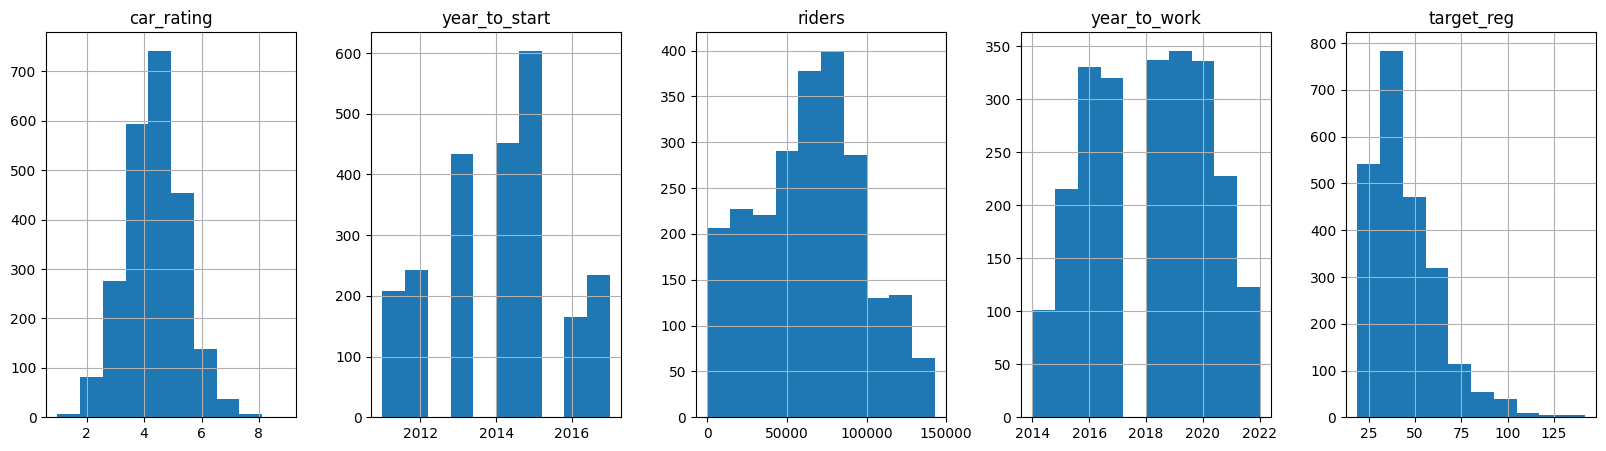

In [20]:
path = '../data/car_train.csv'
train = pd.read_csv(path)
print(train.shape)
train.hist(figsize=(20, 5), layout = (-1, 5))
train.sample(3)

In [21]:
train.describe()

,car_rating,year_to_start,riders,year_to_work,target_reg
count,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000
mean,4.354292,2014.040650,63711.443731,2018.069748,44.946735
std,0.996954,1.685852,33755.012096,2.159484,17.579568
min,0.980000,2011.000000,23.000000,2014.000000,18.920000
25%,3.740000,2013.000000,41053.000000,2016.000000,31.670000
50%,4.360000,2014.000000,64415.000000,2018.000000,40.170000
75%,5.000000,2015.000000,86515.000000,2020.000000,54.790000
max,8.900000,2017.000000,142862.000000,2022.000000,141.630000


In [22]:
path = '../data/car_test.csv'
test = pd.read_csv(path)
print(test.shape)
test.sample(3)

(1913, 8)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work
1873,f16491132W,VW Polo VI,economy,petrol,3.34,2015,75483,2021
373,E-2189846g,Kia Rio X,economy,petrol,4.56,2012,27246,2015
1142,w45505269O,Hyundai Solaris,economy,petrol,3.90,2015,75831,2019


## Классифицируем признаки на типы

In [23]:
features2drop = ['car_id'] # то, что надо выбросить 
targets = ['target_class', 'target_reg'] # таргеты
cat_features = ['car_type', 'fuel_type', 'model'] # категориальные признаки

filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

print('cat_features :', len(cat_features), cat_features)
print('num_features :', len(num_features), num_features)
print('targets', targets)

cat_features : 3 ['car_type', 'fuel_type', 'model']
num_features : 4 ['car_rating', 'year_to_start', 'riders', 'year_to_work']
targets ['target_class', 'target_reg']


## Объявляем модель для кросс-валидации

Чтобы в дальнейшем было удобно обучать и инференсить модели, обученные при помощи кросс-валидации, напишем под это дело отдельный класс. Он будет принимать модель (в нашем случае `catboost`), и обучать несколько ее вариаций - отдельная модель на каждый фолд. Во время инференса будем просто брать тот класс, за который проголосовало наибольшее кол-во моделей.

In [131]:
from sklearn.model_selection import StratifiedKFold
import copy
from collections import Counter
from sklearn.metrics import accuracy_score

class CvModel:
    def __init__(self, clf):
        self.models = []
        self.clf = clf
        self.scores = []
        
    def fit(self, X, y, cv=5):
        self.models = []
        self.scores = []
        
        skf = StratifiedKFold(n_splits=cv)
        for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
            now_model = copy.deepcopy(self.clf)
            X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
            
            now_model.fit(X_train, y_train, 
                          eval_set=(X_val, y_val),
                          early_stopping_rounds=150,
                          verbose=False)
            
            acc = accuracy_score(now_model.predict(X_val), y_val)
            print(f'Fold {i}/{cv} acc = {acc}')
            
            self.scores.append(acc)
            self.models.append(now_model)
        print('Mean acc = {}'.format(np.mean(self.scores)))
            
    def predict_proba(self, X):
        if len(self.models) == 0:
            raise Exception("There is not fitted model")
            
        res = [model.predict_proba(X) for model in self.models]
        return np.sum(res, axis=0)
    
    def predict(self, X):
        if len(self.models) == 0:
            raise Exception("There is not fitted model")
            
        preds = np.concatenate([model.predict(X).reshape(-1, 1) for model in self.models], axis=1)
#         print(preds.shape)
        res = [Counter(el).most_common()[0][0] for el in preds]
        return res

## Обучаем Catboost и делаем прогноз на тест

In [24]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

In [25]:
X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train['target_class']

In [124]:
params_cat = {
    "n_estimators": 1500,
    "learning_rate": 0.03,
    "depth": 5,
    "use_best_model": True,
    "cat_features": cat_features,
    "text_features": [],
    "l2_leaf_reg": 1,
    "bagging_temperature": 2,
    "random_state": 42,
    "loss_function": 'MultiClass',
    'eval_metric': 'Accuracy',
}

In [127]:
clf = CatBoostClassifier(**params_cat)
cv_model = CvModel(clf)

In [128]:
cv_model.fit(X, y)

Fold 0/5 acc = 0.13034188034188035
Fold 1/5 acc = 0.1346153846153846
Fold 2/5 acc = 0.14775160599571735
Fold 3/5 acc = 0.14989293361884368
Fold 4/5 acc = 0.14132762312633834
Mean acc = 0.14078588553963284


In [132]:
test['target_class'] = cv_model.predict(test[filtered_features])
test[['car_id', 'target_class']].to_csv('../subs/simple_baseline_v1.csv', index=False)
print('CSV file saved!')

CSV file saved!


## Добавим информацию про поездки из rides_info


🏇 Информация про поездки - `rides_info.csv`.  **Пояснение столбцов:**
- `user_id` / `car_id` / `ride_id` - идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` - дата поездки и рейтинг, поставленный водителем 
- `ride_duration` / `distance` / `ride_cost` -  длительность (время),  пройденное расстояние, стоимость поездки 
- `speed_avg` / `speed_max` - средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` - количество остановок (паузы) и флаг - была ли дозаправка.
- `user_ride_quality` - оценка манеры вождения машины водителя, определенная скоринговой ML системой сервиса.
- `deviation_normal` - общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы). 


In [133]:
path = '../data/rides_info.csv'
rides = pd.read_csv(path)
rides.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
407822,k41784113k,d-1069476v,a1L,2020-03-15,1.29,39,346,50,97.879583,0,2.025980e+03,0,-14.210711,41.449
232130,U85089217C,Q-4235244W,B1c,2020-01-08,5.20,32,504,29,51.000000,1,6.053732e+02,0,2.787598,-21.547
664957,Q16984075g,u79013135M,R1R,2020-02-24,4.48,31498,377970,48,91.200849,0,1.531051e+06,0,-13.603495,7.464
448028,d18561117L,f16848135A,y1o,2020-03-21,5.01,11,139,53,58.000000,2,3.660006e+02,0,15.940848,-5.767
358022,J12170823W,Z17729553x,V1t,2020-02-25,2.95,86,769,40,74.000000,2,2.577932e+03,0,22.540696,20.243


In [134]:
f = lambda x: x.nunique()
rides_df_gr = rides.groupby('car_id', as_index=False).agg(mean_rating = ('rating', 'mean'),
                                                   distance_sum = ('distance', 'sum'),
                                                   rating_min = ('rating', 'min'),
                                                   speed_max = ('speed_max', 'max'),
                                                   user_ride_quality_median = ('user_ride_quality', 'median'), 
                                                   deviation_normal_count = ('deviation_normal', 'count'),
                                                   user_uniq = ('user_id', f))


rides_df_gr.head(2)

,car_id,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,A-1049127W,4.255172,1.125753e+07,0.1,179.729652,-0.288229,174,172
1,A-1079539w,4.088046,1.912765e+07,0.1,184.505566,2.508746,174,173


In [135]:
def add_featues(df):
    
    if 'mean_rating' not in df.columns:
        data = df.merge(rides_df_gr, on = 'car_id', how = 'left')
    else:
        data = df.copy()
    
    data['sum_rating'] = data['mean_rating'] * data['riders']
    data['year_in_work'] = data['year_to_work'] - data['year_to_start']
    data['mean_distance'] = data['distance_sum'] / data['year_in_work']
    data['riders_per_year'] = data['riders'] / data['year_in_work']
    
    return data
    
    
train = add_featues(train)
test = add_featues(test)

In [136]:
train.sample(2)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq,sum_rating,year_in_work,mean_distance,riders_per_year
2237,O-1977280N,Skoda Rapid,economy,petrol,5.40,2014,65808,2016,30.46,gear_stick,...,1.450046e+07,0.1,106.352552,1.217794,174,172,306835.473103,2,7.250231e+06,32904.0
2021,m-1232449r,Renault Kaptur,standart,petrol,4.86,2012,21331,2017,30.49,engine_overheat,...,2.075052e+07,0.1,188.000000,-4.738577,174,173,91056.399770,5,4.150104e+06,4266.2


In [137]:
# train.to_csv('../tmp_data/quickstart_train.csv', index=False)

In [138]:
# test.to_csv('../tmp_data/quickstart_tra.csv', index=False)

# Снова обновляем типы фичей

In [139]:
filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]


print('num_features :', len(num_features), num_features)
print('cat_features :', len(cat_features), cat_features)
print('targets', targets)

num_features : 15 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq', 'sum_rating', 'year_in_work', 'mean_distance', 'riders_per_year']
cat_features : 3 ['car_type', 'fuel_type', 'model']
targets ['target_class', 'target_reg']


# Обучаем `CatBoost` на новых данных и делаем новый прогноз

In [141]:
X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train['target_class']

In [142]:
clf = CatBoostClassifier(**params_cat)
cv_model = CvModel(clf)

In [143]:
cv_model.fit(X, y)

Fold 0/5 acc = 0.7841880341880342
Fold 1/5 acc = 0.8034188034188035
Fold 2/5 acc = 0.8137044967880086
Fold 3/5 acc = 0.8394004282655246
Fold 4/5 acc = 0.7987152034261242
Mean acc = 0.807885393217299


In [145]:
test['target_class'] = cv_model.predict(test[filtered_features])
test[['car_id', 'target_class']].to_csv('../subs/simple_baseline_v2.csv', index=False)
print('CSV file saved!')

CSV file saved!


## Смотрим на важность признаков

In [146]:
import shap

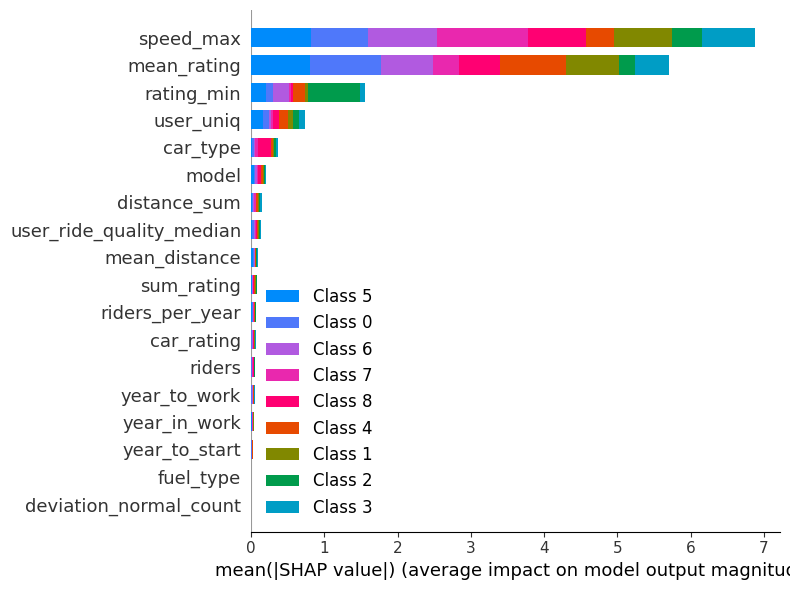

In [148]:
# Построим усредненный shap values 
explainer = shap.TreeExplainer(cv_model.models[0])
shap_values = explainer.shap_values(Pool(X, y, cat_features=cat_features))

shap.summary_plot(shap_values, X, plot_size=0.25,)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
invalid value encountered in subtract


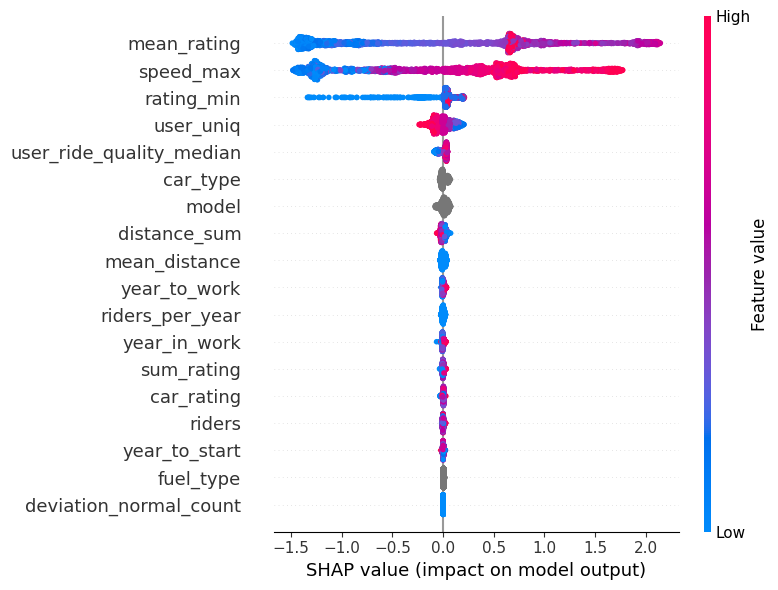

In [149]:
# построем shap values отдельно для нулевого класса
shap.summary_plot(shap_values[0], X, plot_size=0.25,)

## Что дальше? Зашли решение на Kaggle

- Нажимаем `Save Version`
- Проверяем, что в `Advanced Settings` выбрано - всегда сохранять результаты ноутбука.
- Тип сохранения `Save & Run All (Commit)`
- Жмем окончательно кнопку `Save`

**Как еще можно улучшить это решение?**

- Во время кросс валидации делать не `hard voting`, а `soft voiting`
- Нагенерить новых фичей (может быть даже при помощи `AutoML`)
- Присоединить сюда информацию о машинах из модуля про парсинг
- Перебрать гиперпараметры при помощи `Optuna`
- Сбледнить/застекать модели